<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Network communities </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>March 4, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. What are network communities?
<hr style="height:1px;border:none" />

In some network data, you may observe that some nodes are strongly interconnected among themselves, forming clusters. On the other hand, connections between such clusters are very sparse. Such interconnected clusters of nodes are often referred as clusters, ***communities***, or ***modules***. Here is a toy example of such clusters. 

`<ToyCommunityExamples.py>`

In [1]:
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for a

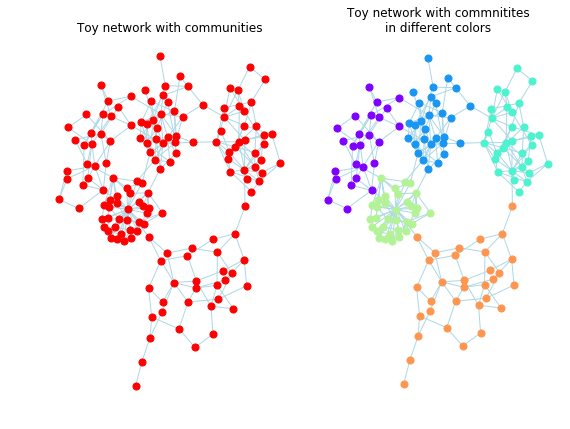

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import LFR_benchmark_graph

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


# first, a simple toy example of modular network
n = 150
tau1 = 3.0
tau2 = 2.0
mu = 0.0675
G_list = []
G = LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5,
                        min_community=25, seed=10)



# drawing the graph --- Kamada-Kawai layout
# without community assignment
plt.figure(figsize=[8,6])

plt.subplot(121)
pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
plt.title('Toy network with communities')
plt.axis('off')

# extracting community assignment indices
commIndSet = {frozenset(G.nodes[v]['community']) for v in G}
commInd = [list(x) for x in iter(commIndSet)]
nComm = len(commInd)

# drawing with community assignment
plt.subplot(122)
node_color_list = get_cmap(nComm+1,'rainbow')
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
for iComm in range(nComm):
    nx.draw_networkx_nodes(G, pos, nodelist=commInd[iComm],
                           node_color = node_color_list(iComm),
                           node_size=50)
plt.title('Toy network with commnitites\nin different colors')
plt.axis('off')

plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

In this particular example, only 6.75% of edges are connecting communities, while the remaining 93.25% of edges are for within-community connections. Since inter-community connections are so sparse, communities are readily identifiable just by looking at the network. However, as the fraction of inter-community connections increases, communities becomes less obvious. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

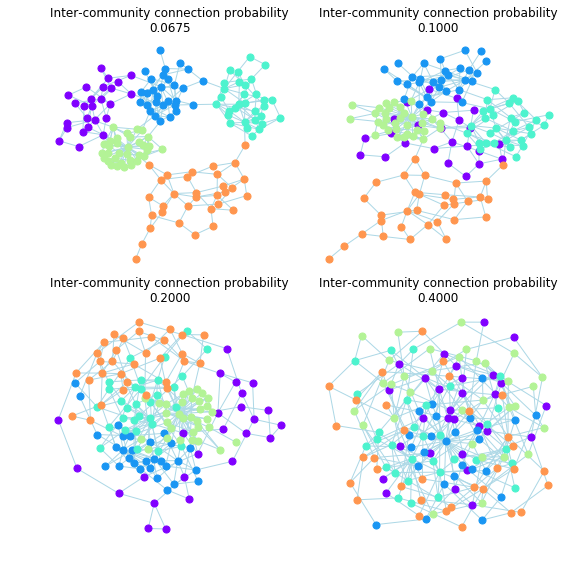

In [5]:
# generating toy networks with different inter-community connection prob
n = 150
tau1 = 3.0
tau2 = 2.0
mu = [0.0675, 0.10, 0.20, 0.40]
G_list = []
for imu in mu:
    G = LFR_benchmark_graph(n, tau1, tau2, imu, average_degree=5,
                            min_community=25, seed=10)
    G_list.append(G)

    
    

# drawing the graph --- Kamada-Kawai layout
plt.figure(figsize=[8,8])
for i,imu in enumerate(mu):
    plt.subplot(2,2,i+1)
    G = G_list[i]
    commIndSet = {frozenset(G.nodes[v]['community']) for v in G}
    commInd = [list(x) for x in iter(commIndSet)]
    nComm = len(commInd)
    node_color_list = get_cmap(nComm+1,'rainbow')

    pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
    for iComm in range(nComm):
        nx.draw_networkx_nodes(G, pos, nodelist=commInd[iComm],
                               node_color = node_color_list(iComm),
                               node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='lightblue')
    plt.title('Inter-community connection probability\n%6.4f' % imu)
    plt.axis('off')

plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.9,
                    left=0.05, right=0.95)
plt.show()

## Why should we care about network communities?

Because identifying network communities often reveal the underlying partition or grouping of nodes solely based on network connections. Here are two examples of that.

The first example shows the network modules in the karate club network, estimated by two methods (Girvan-Newman method and Louvain method). The Girvan-Newman method is available as the **`girvan_newman`** function in **`networkx.algorithms.community`**. Unfortunately this function returns a series of modular partitions with different numbers of communities (between 1 and n (number of nodes)). Thus I wrote a small function to find the optimal modular partition with the right number of modules (as determined by **modularity**, discussed later). The Louvain method is implemented as the **`best_partition`** function in the **`community`** library (a.k.a., **`python-louvain`**). 

The example network represents a karate club at a university, split into two groups due to an internal dispute. This data set is a well-studied network in social science. 

`<CommunityExamples.py>`

In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman, modularity
import community   # Louvain method

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm, end='')
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if verbose:
            print('  Modularity : %6.4f' % Q)
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition



##### loading network data
# Karate network
G_karate = nx.read_gml('DataModules/karate.gml', label='id')  
# Football network
G_football = nx.read_gml('DataModules/football.gml')  


##### Community detection 
# Community detection with the girvan-newman algorithm
commInd_karate = girvan_newman_opt(G_karate)
commInd_football = girvan_newman_opt(G_football)
# converting the partitions into dictionaries
partition_karate_GN = {}
for i,iComm in enumerate(commInd_karate):
    for iNode in iComm:
        partition_karate_GN[iNode] = i
partition_football_GN = {}
for i,iComm in enumerate(commInd_football):
    for iNode in iComm:
        partition_football_GN[iNode] = i


# Community detection with the Louvain method
partition_karate_L = community.best_partition(G_karate)
partition_football_L = community.best_partition(G_football)

Let's visualize this network, with modules in different colors.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

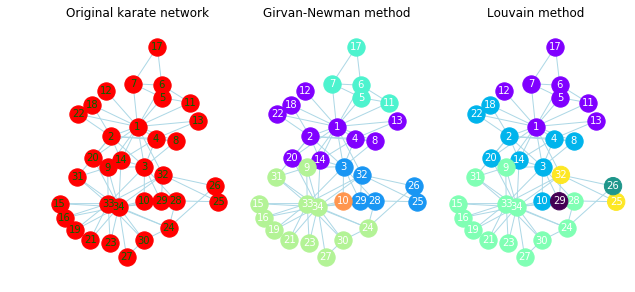

In [9]:
###### drawing the graph (karate network)
plt.figure(figsize=[9,4])

# first, graph without community assignments
plt.subplot(131)
pos = nx.kamada_kawai_layout(G_karate, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G_karate, pos)
nx.draw_networkx_edges(G_karate, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_color='DarkGreen')
plt.title('Original karate network')
plt.axis('off')
plt.xlim([-0.6, 0.65])
plt.ylim([-0.85, 1.2])

# next, graph with communities in different colors (Girvan-Newman)
plt.subplot(132)
nComm = max([comm for comm in partition_karate_GN.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_karate_GN.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_karate, pos, 
                           nodelist=nodeList,
                           node_color = node_color_list(iComm),
                           node_size=300)
nx.draw_networkx_edges(G_karate, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_color='White')
plt.title('Girvan-Newman method')
plt.axis('off')
plt.xlim([-0.6, 0.65])
plt.ylim([-0.85, 1.2])

# finally, graph with communities in different colors (Louvain)
plt.subplot(133)
nComm = max([comm for comm in partition_karate_L.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_karate_L.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_karate, pos, 
                           nodelist=nodeList,
                           node_color = node_color_list(iComm),
                           node_size=300)
nx.draw_networkx_edges(G_karate, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_color='White')
plt.title('Louvain method')
plt.axis('off')
plt.xlim([-0.6, 0.65])
plt.ylim([-0.85, 1.2])

plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

The second example is the college football network. As you can imagine, schools belonging to the same conference tend to play more often among themselves, compared to schools in different conferences. The two estimation methods produced a fairly good result predicting these conferences.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

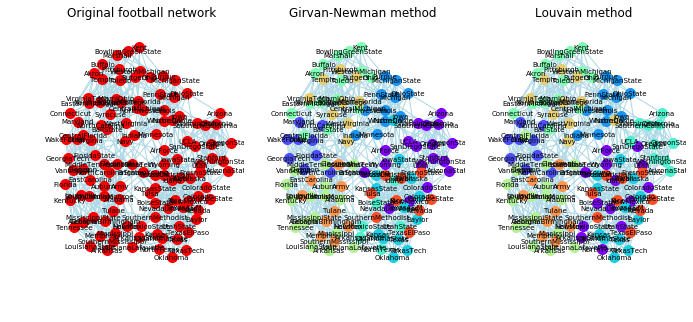

In [10]:
#### drawing the graph (football network)
plt.figure(figsize=[10,4.5])
plt.subplot(131)

# first, graph without community assignments
pos = nx.kamada_kawai_layout(G_football, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G_football, pos, node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='Black')
plt.title('Original football network')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])

# next, graph with communities in different colors (Girvan-Newman)
plt.subplot(132)
nComm = max([comm for comm in partition_football_GN.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_football_GN.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_football, pos, 
                           nodelist=nodeList,
                           node_color = node_color_list(iComm),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='black')
plt.title('Girvan-Newman method')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])

# next, graph with communities in different colors (Louvain)
plt.subplot(133)
nComm = max([comm for comm in partition_football_L.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_football_L.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_football, pos, 
                           nodelist=nodeList,
                           node_color = node_color_list(iComm),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='black')
plt.title('Louvain method')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])


plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

## 2. Modularity
<hr style="height:1px;border:none" />

## How clustered is a network?

As I mentioned earlier, some networks consists of highly interconnected communities, while others are not. If you have community partition information, you can examine how modular a network is, using a metric called **modularity**. In a nutshell, modularity examines the fraction of within community edges and compared that to the expected fraction if connections were at random. Modularity ranges from -0.5 to 1.0. A negative modularity measure means communities are likely random, whereas a high positive modularity means the network is highly modular (i.e., communities likely exist).

The **`modularity`** function in **`networkx.algorithms.community`** calculates modularity based on the community partition information (true partition or estimated partition). 
You may notice that the earlier toy example lists the modularity measures for both the true community partition as well as estimated partitions (see above). Modularity can be estimated by
```python
    Q = modularity(G, commInd)
```
where **`G`** is a graph object and **`commInd`** is partition information, can be an output from a community detection algorithm, or a list of lists of nodes describing communities. 

## Girvan-Newman revisited

My function **`girvan_newman_opt`** calculates the modularity for each partition based on the Girvan_Newman method, and returns the partition with the highest modularity as the optimal partition.
```python
# girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm)
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition
```

### Exercise
1. **Modularity, karate network**. Calculate the modularity for the karate network community results by the label propagation method and the Girvan-Newman method (see **`CommunityExamples.py`** above).
2. **Modularity, football network**. Calculate the modularity for the football network community results by the label propagation method and the Girvan-Newman method (see **`CommunityExamples.py`** above).


# 4. Accuracy of community partition
<hr style="height:1px;border:none" />

In some network data (such as our football network), the true community organization is known (such as conferences in our football network). In such a case, we can examine the accuracy of estimated community partitions by using the adjusted Rand index (ARI). As you recall, from our clustering lecture, the ARI describes the similarity in clustering. The ARI ranges from -1.0 to 1.0. ARI close to 0 means the cluster (or community in this case) labels are random, where as ARI close to 1.0 means similarity in community labels.

Here is an example of ARI used in the football network.

`<RandExamples.py>`

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import girvan_newman, modularity
from sklearn.metrics import adjusted_rand_score


# girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm)
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition


# loading network data
G_football = nx.read_gml('football.gml')  # Football network
y_true = [d['value'] for n, d in G_football.nodes(data=True)]  # true conf labels

As in a machine learning setting, we need to create a list of true community labels, **`y_true`**. Now let's estimate community organization with the label propagation method.

In [8]:
# Community detection with the label propagation algorithm
commIndSet_football = label_propagation_communities(G_football)
commInd_football_lp = [list(x) for x in iter(commIndSet_football)]
# generating the detected community labels & adj rand index
y_pred_lp = [n for n in G_football.nodes()]
      # make a node list. Then replace the node name with the predicted
      # communitiy assignment.
for j,jComm in enumerate(commInd_football_lp):
    for k in jComm:
        y_pred_lp[y_pred_lp.index(k)] = j

Here, we need to do a trick to generate our `y_pred` list. There is no straightforward way to do this, so I am making a list of nodes, then replacing each node label with the corresponding community number it belongs to. Then finally calculating the ARI.

In [9]:
rand_lp = adjusted_rand_score(y_true,y_pred_lp)

We do a similar thing for the Girvan-Newman method as well.

In [10]:
# Community detection with the girvan-newman algorithm
commIndSet_football = girvan_newman_opt(G_football)
commInd_football_gn = [list(x) for x in iter(commIndSet_football)]
# generating the detected community labels & adj rand index
y_pred_gn = [n for n in G_football.nodes()]
      # make a node list. Then replace the node name with the predicted
      # communitiy assignment.
for j,jComm in enumerate(commInd_football_gn):
    for k in jComm:
        y_pred_gn[y_pred_gn.index(k)] = j
rand_gn = adjusted_rand_score(y_true,y_pred_gn)

Finally re-drawing community organizations (true and predicted), along with the Rand indices.

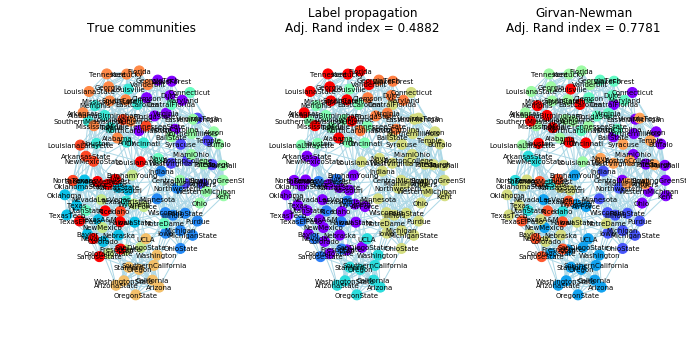

In [11]:
# drawing the graph (football network)
plt.figure(figsize=[10,4.5])
plt.subplot(131)

# first, graph with true communitities
pos = nx.kamada_kawai_layout(G_football, weight=None) # positions for all nodes
for iComm in range(max(y_true)+1):
    nodeList = [n for n, d in G_football.nodes(data=True) if d['value']==iComm]
    nx.draw_networkx_nodes(G_football, pos, nodelist=nodeList,
                           cmap=plt.cm.rainbow, vmin=0, vmax=max(y_true),
                           node_color = [iComm]*len(nodeList),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos, edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='Black')
plt.title('True communities')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])

# next, graph with communities in different colors (label propagation)
plt.subplot(132)
for iComm in range(len(commInd_football_lp)):
    nx.draw_networkx_nodes(G_football, pos, nodelist=commInd_football_lp[iComm],
                           cmap=plt.cm.rainbow,
                           vmin=0, vmax=len(commInd_football_lp)-1,
                           node_color = [iComm]*len(commInd_football_lp[iComm]),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='Black')
plt.title('Label propagation\nAdj. Rand index = %6.4f' % rand_lp) 
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])


# (girvan-newman)
plt.subplot(133)
for iComm in range(len(commInd_football_gn)):
    nx.draw_networkx_nodes(G_football, pos, nodelist=commInd_football_gn[iComm],
                           cmap=plt.cm.rainbow,
                           vmin=0, vmax=len(commInd_football_gn)-1,
                           node_color = [iComm]*len(commInd_football_gn[iComm]),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='Black')
plt.title('Girvan-Newman\nAdj. Rand index = %6.4f' % rand_gn)
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])


plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

Here is another example, based on our toy network data. As you can see, the community detection algorithms do make a difference in the accuracy of the results.

In [ ]:
# %load ../Codes/netCommExamples/ToyRandExamples.py
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import LFR_benchmark_graph
from networkx.algorithms.community import girvan_newman 
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import modularity
from sklearn.metrics import adjusted_rand_score

# girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm)
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition



# generating toy networks with different inter-community connection prob
n = 150
tau1 = 3.0
tau2 = 2.0
mu = [0.0675, 0.20]
G_list = []
trueCommInd_list = []
y_true_list = []
for imu in mu:
    G = LFR_benchmark_graph(n, tau1, tau2, imu, average_degree=5,
                            min_community=25, seed=10)
    G_list.append(G)
    commIndSet = {frozenset(G.nodes[v]['community']) for v in G}
    commInd = [list(x) for x in iter(commIndSet)]
    trueCommInd_list.append(commInd)
    # generating the true community labels
    y_true = np.ones(n)
    for i,iComm in enumerate(commInd):
        y_true[iComm] = i
    y_true_list.append(y_true)



# communitiy detection by Girvan-Newman method
commInd_gn_list = []
rand_gn_list = []
for i,imu in enumerate(mu):
    commInd = girvan_newman_opt(G_list[i])
    commInd_gn_list.append(commInd)
    # generating the detected community labels
    y_pred = np.ones(n)
    for j,jComm in enumerate(commInd):
        y_pred[list(jComm)] = j
    ari = adjusted_rand_score(y_true_list[i],y_pred)
    rand_gn_list.append(ari)



# communitiy detection by label propagation
commInd_lp_list = []
rand_lp_list = []
for i,imu in enumerate(mu):
    commIndSet = label_propagation_communities(G_list[i])
    commInd = [list(x) for x in iter(commIndSet)]
    commInd_lp_list.append(commInd)
    # generating the detected community labels
    y_pred = np.ones(n)
    for j,jComm in enumerate(commInd):
        y_pred[list(jComm)] = j
    ari = adjusted_rand_score(y_true_list[i],y_pred)
    rand_lp_list.append(ari)



# drawing the graph --- Kamada-Kawai layout
plt.figure(figsize=[7,9])
for i,imu in enumerate(mu):
    # true module assignment
    plt.subplot(3,2,i+1)
    G = G_list[i]
    commIndSet = {frozenset(G.nodes[v]['community']) for v in G}
    commInd = [list(x) for x in iter(commIndSet)]

    pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
    for iComm in range(len(commInd)):
        nx.draw_networkx_nodes(G, pos, nodelist=commInd[iComm],
                               cmap=plt.cm.rainbow, vmin=0, vmax=len(commInd)-1,
                               node_color = [iComm]*len(commInd[iComm]),
                               node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='lightblue')
    plt.title('True communities\nprob = %6.4f' % imu)
    plt.axis('off')

    # girvan-newman
    plt.subplot(3,2,i+3)
    for iComm, iCommInd in enumerate(commInd_gn_list[i]):
        nx.draw_networkx_nodes(G, pos, nodelist=list(iCommInd),
                               cmap=plt.cm.rainbow, vmin=0,
                               vmax=len(commInd_gn_list[i])-1,
                               node_color = [iComm]*len(iCommInd),
                               node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='lightblue')
    plt.title('Girvan-Newman\nAdj. Rand index: %6.4f' % rand_gn_list[i])
    plt.axis('off')

    # label propagation
    plt.subplot(3,2,i+5)
    for iComm, iCommInd in enumerate(commInd_lp_list[i]):
        nx.draw_networkx_nodes(G, pos, nodelist=list(iCommInd),
                               cmap=plt.cm.rainbow, vmin=0,
                               vmax=len(commInd_lp_list[i])-1,
                               node_color = [iComm]*len(iCommInd),
                               node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='lightblue')
    plt.title('Label propagation\nAdj. Rand index: %6.4f' % rand_lp_list[i])
    plt.axis('off')


plt.subplots_adjust(hspace=0.3, wspace=0.05, bottom=0.025, top=0.925,
                    left=0.05, right=0.95)
plt.show()